## Examining Network Assortativity via H3 Grids (20 minutes)

Output from Urbanity can be used for various complex network analytical tasks. This notebook demonstrates how graph structure and network contextual attributes can be used to visualise and analyse urban segregation. Network assortativity (Newman, 2003) is a measure of co-similarity between pairs (like the familiar pearson correlation), except that the set of pairs consist of adjacent neighbouring nodes that share an edge. More specifically, the concept is useful to understand how values between neighbours connected by an edge are similar/different to one another. Network assortativity values range from dissociative (-1) to associative (+1). For example, if network nodes tend to have similar values to their adjacent neighbours, then the network will have positive assortativity. On the other hand, if high values tend to be placed next to low values, then the network will display negative assortativity. Such a measure corresponds intuitively to a measure of urban segregation where we are interested in how values change from one location to another.

We begin by installing and importing the relevant libraries. `h3` is an open source package by Uber which allows users to plot hexagonal grids of varying spatial resolution. 

In [4]:
# Install h3 from command line
!python -m pip install "h3==3.7.4"
!python -m pip install "shapely==2"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 5.0 MB/s eta 0:00:00 MB/s eta 0:00:01m
  Attempting uninstall: shapely
    Found existing installation: Shapely 1.8.5.post1
    Uninstalling Shapely-1.8.5.post1:
      Successfully uninstalled Shapely-1.8.5.post1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyrosm 0.6.2 requires shapely>=2.0.1, but you have shapely 2.0.0 which is incompatible.


In [1]:
import h3
print(h3.__version__)


3.7.4


In [20]:
# Import external packages
import h3
from shapely import wkt
import urbanity as urb
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon

### Singapore: Urban Greenery 
#### Load geographic shapefile
In this example, we employ Singapore as a case study. Our goal is to produce a h3 grid showcasing network assortivity of green view index in Singapore. This will allow us to determine the degree of segregation of urban greenery throughout Singapore. We begin by loading our shapefile of Singapore and visualising it:

In [21]:
# !ls data

In [22]:
sg_gdf = gpd.read_file('/home/srg/projects/urbanity/data/singapore.geojson')

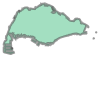

In [23]:
sg_gdf.geometry.values[0]

#### Generate h3 (hexagonal) grids 
Next, we generate hexagonal grids of resolution [8](https://h3geo.org/docs/core-library/restable) which correspond approximately to 0.74 $km^2$. This is done by first passing our bounding extent of `sg_gdf` to the `h3.polyfill` function. 

In [37]:
# print((sg_gdf.geometry[0].geoms[0]))  # Check the geometry type
# print(type(sg_gdf.geometry[0].geoms))

POLYGON ((103.64802165609166 1.239634864479302, 103.64799621125925 1.239617055829584, 103.6479919346243 1.239612488508003, 103.64799108146848 1.239606194099051, 103.64800693455904 1.239572978055611, 103.64801121079401 1.239570373798635, 103.64802212791054 1.239568855241862, 103.64804457209395 1.239580821511368, 103.64806766413362 1.239579520858201, 103.6480830636161 1.239583002825821, 103.64809632632945 1.239587779687128, 103.64810851062293 1.239595386216399, 103.64811428682734 1.239600812785842, 103.64812070184833 1.239606681632486, 103.64812390923089 1.239611457785914, 103.64812690098393 1.239616015973288, 103.64814935416985 1.239627747108915, 103.6481529744631 1.239638400730116, 103.64814434714023 1.239660511736568, 103.64816941465321 1.239677497390457, 103.64819706529417 1.239631467387819, 103.64824644560022 1.239664923155899, 103.64820410255885 1.239734094710023, 103.64815471321367 1.23970140764683, 103.64816334010754 1.239685473422381, 103.64813850601296 1.239671318433136, 103.64

In [41]:
# Obtain hexagonal ids by specifying geographic extent and hexagon resolution
geom = sg_gdf.geometry[0]
hexagon_ids = set()

if isinstance(geom, MultiPolygon):
    for polygon in geom.geoms:  # Iterate over individual Polygons
        geojson_polygon = polygon.__geo_interface__  #mapping(polygon)  # Convert to valid GeoJSON
        hexagon_ids.update(h3.polyfill(geojson_polygon, 8, geo_json_conformant=True))
else:
    geojson_polygon = mapping(geom)
    hexagon_ids = h3.polyfill(geojson_polygon, 8, geo_json_conformant=True)

# hexagon_ids = h3.polyfill(sg_gdf.geometry[0].__geo_interface__, 8, geo_json_conformant = True)

# Custom function to be applied to each hexagonal id (from previous step), converting them to valid shapely polygons
polygonise = lambda hex_id: Polygon(
                                h3.h3_to_geo_boundary(
                                    hex_id, geo_json=True)
                                    )

# Map custom function to polygon ids with EPSG:4326 coordinate reference system
hexagonal_polygons = gpd.GeoSeries(list(map(polygonise, hexagon_ids)), 
                                      index=hexagon_ids, 
                                      crs="EPSG:4326" 
                                     )

With these simple steps, we have completed the first part and obtained our hexagonal grids for Singapore's boundary. We can plot `hexagonal_polygons` to see what the grids look like:

In [42]:
# hexagon_ids

<Axes: >

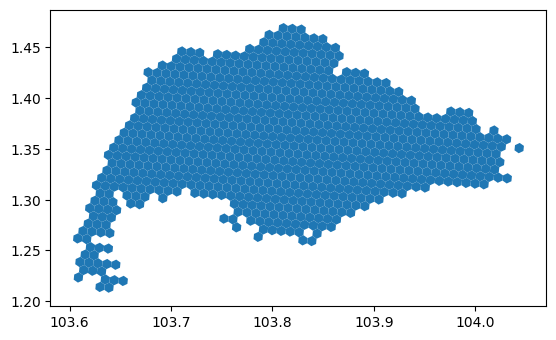

In [44]:
hexagonal_polygons.plot()

#### Merging urban greenery information with hexagon geometric grids
The next step involves linking street view imagery information (green view index) with our hexagon geometric grids. Broadly speaking, this consists of the following steps: 1) converting our hexagon geometry list to a valid geopandas GeoDataFrame to facilitate merging; 2) loading network node and edge information; 3) finding spatial intersection of nodes and edges with each corresponding hexagonal grid cell. We go through each step in detail below:

In [45]:
### Step 1: Convert hexagonal geometry list to geopandas Geodataframe

# Create geodataframe object with EPSG:4326 coordinate reference system and geometry as our hexagonal_polygons list. Data is set to None.
hex_gdf = gpd.GeoDataFrame(data=None, crs="EPSG:4326", geometry = hexagonal_polygons)

# Reset index to move hexagonal polygon id list to its own column
hex_gdf = hex_gdf.reset_index()

# Rename column names to allow spatial overlay operation later
hex_gdf.columns = ['hexid', 'geometry']

After these simple steps, our list of hexagonal polygons has been converted successfully to a geopandas dataframe. We can then use this as input for spatial overlay operations later. We show the first five rows of our new hexagonal dataframe `hex_gdf` below:

In [46]:
hex_gdf.head()

,hexid,geometry
0,886520ca09fffff,"POLYGON ((103.73438 1.32627, 103.73488 1.33135..."
1,886520c831fffff,"POLYGON ((103.68894 1.4067, 103.68944 1.41179,..."
2,886520c945fffff,"POLYGON ((103.76251 1.4317, 103.76301 1.43679,..."
3,886520d94bfffff,"POLYGON ((103.86512 1.3007, 103.86562 1.30578,..."
4,886520cab5fffff,"POLYGON ((103.65799 1.36298, 103.65848 1.36807..."


In [47]:
### Step 2: Loading network node and edge information

# Load Singapore 100m node attributes from the Global Urban Network (GUN) dataset
singapore_100m_nodes = gpd.read_file('https://figshare.com/ndownloader/files/39360302')

# Load Singapore 100m edge attributes from the Global Urban Network (GUN) dataset
singapore_100m_edges = pd.read_csv('https://figshare.com/ndownloader/files/39360299', index_col=0)

# Convert edges geometry from string (due to csv storage) to shapely linestring object. Note: csv was used to facilitate storing of tuple valued columns. 
singapore_100m_edges['geometry'] = singapore_100m_edges['geometry'].apply(wkt.loads)

# Return a new dataframe with start node (u), end node (v), length in metres, and linestring geometry
singapore_100m_edges = gpd.GeoDataFrame(data = {'u':singapore_100m_edges['u'], 
                                          'v':singapore_100m_edges['v'], 
                                          'length':singapore_100m_edges['length']},
                                    crs="EPSG:4326", 
                                    geometry = singapore_100m_edges['geometry'])

After successfully loading our network node and edge information, we display the first five entries in each geodataframe. For nodes, we select only attributes of interest `Green View`. 

In [48]:
singapore_100m_nodes.head()[['osmid','x','y','Green View','geometry']]

,osmid,x,y,Green View,geometry
0,4748500344,103.830061,1.306018,0.517850,POINT (103.83006 1.30602)
1,6427627507,103.830112,1.305992,0.517850,POINT (103.83011 1.30599)
2,74355703,103.839288,1.313432,0.378129,POINT (103.83929 1.31343)
3,2666453628,103.839495,1.313585,0.406765,POINT (103.8395 1.31358)
4,3181999572,103.839882,1.313886,0.483286,POINT (103.83988 1.31389)


In [49]:
singapore_100m_edges.head()

,u,v,length,geometry
0,4748500344,6427627507,6.321,"LINESTRING (103.83006 1.30602, 103.83011 1.30599)"
1,4748500344,6330272156,18.593,"LINESTRING (103.82991 1.3061, 103.83006 1.30602)"
2,4748500344,4748500339,40.520,"LINESTRING (103.83006 1.30602, 103.83008 1.306..."
3,6427627507,4748500344,6.321,"LINESTRING (103.83006 1.30602, 103.83011 1.30599)"
4,6427627507,4748500346,19.905,"LINESTRING (103.83011 1.30599, 103.83014 1.305..."


We proceed to the final preparatory step to conduct a spatial overlay of network nodes and edges with our hexagonal geodataframe. We can easily accomplish this in one line with the `overlay` method which is part of the GeoDataFrame class. After spatial intersection, we visualise the first five rows to see that each linestring has been assigned to its corresponding hexagonal id.

In [50]:
### Step 3 (Final Step): spatial intersection of network and hexagonal grids

hex_intersection = singapore_100m_edges.overlay(hex_gdf, how='intersection')
hex_intersection.head()

,u,v,length,hexid,geometry
0,4748500344,6427627507,6.321,886520d825fffff,"LINESTRING (103.83006 1.30602, 103.83011 1.30599)"
1,4748500344,6330272156,18.593,886520d825fffff,"LINESTRING (103.82991 1.3061, 103.83006 1.30602)"
2,4748500344,4748500339,40.520,886520d953fffff,"LINESTRING (103.83013 1.30615, 103.83023 1.30634)"
3,4748500344,4748500339,40.520,886520d825fffff,"LINESTRING (103.83006 1.30602, 103.83008 1.306..."
4,6427627507,4748500344,6.321,886520d825fffff,"LINESTRING (103.83006 1.30602, 103.83011 1.30599)"


To make things clearer, we can show how many edges intersect with each hexagonal id by showing the count of edges by each hexid group. We show the first five and last five entry below.

In [51]:
hex_intersection.hexid.value_counts()[[0,1,2,3,4,-5,-4,-3,-2,-1]]

hexid
886520d943fffff    1070
886520db37fffff    1028
886520d869fffff     978
886520d90bfffff     978
88652636cbfffff     952
886520cb67fffff       2
886520caa9fffff       2
886520ca85fffff       2
88652636b3fffff       2
886520c83dfffff       2
Name: count, dtype: int64

As shown above, there are hexagonal grids with only two edges. This is an issue for results interpretation as the number of observation counts might not give robust estimates. Later we will see how we can account for this by filtering out hexagonal grids with observation count less than a given count threshold (e.g., 30). For now, we note the problem and proceed to merge attribute information `Green View` with our network edges. First, we create a python dictionary `osmid_to_value` that maps osmids to their green view value. We display the first five rows below:

In [52]:
# Specify target column of interest
column_of_interest = ['Green View']

# Create empty dictionary to map Green View value to OSMID
osmid_to_value = {}
for osmid in list(singapore_100m_nodes['osmid']):
    osmid_to_value[osmid] = {}
    
# Add Green View value to their corresponding osmid key
for col in column_of_interest:
    for oid,value in zip(list(singapore_100m_nodes['osmid']),list(singapore_100m_nodes[col])):
        osmid_to_value[oid][col] = value

In [53]:
# Simple for loop to visualise the first five rows of our dictionary that maps osmid to Green View value
for i, k in enumerate(osmid_to_value.items()):
    if i < 5:
        print(k)

(4748500344, {'Green View': 0.51785})
(6427627507, {'Green View': 0.51785})
(74355703, {'Green View': 0.3781290322580645})
(2666453628, {'Green View': 0.4067647058823529})
(3181999572, {'Green View': 0.48328571428571426})


With our mapping dictionary set up, we can now loop through our network edges and add start and end node `Green View` to our `hex_intersection` dataframe in a straightforward manner. We do this by iterating looking up their values based on osmid from our `osmid_to_value` dictionary and creating new columns for the `hex_intersection` dataframe. We visualise our modified dataframe and note the addition of two columns: `u_Green View` and `v_Green View`.

In [54]:
for col in column_of_interest:
    hex_intersection[f'u_{col}'] = [osmid_to_value[i][col] for i in hex_intersection['u']]
    hex_intersection[f'v_{col}'] = [osmid_to_value[i][col] for i in hex_intersection['v']]

In [55]:
hex_intersection.head()[['u','v','hexid','u_Green View','v_Green View', 'geometry']]

,u,v,hexid,u_Green View,v_Green View,geometry
0,4748500344,6427627507,886520d825fffff,0.51785,0.517850,"LINESTRING (103.83006 1.30602, 103.83011 1.30599)"
1,4748500344,6330272156,886520d825fffff,0.51785,0.524368,"LINESTRING (103.82991 1.3061, 103.83006 1.30602)"
2,4748500344,4748500339,886520d953fffff,0.51785,0.526789,"LINESTRING (103.83013 1.30615, 103.83023 1.30634)"
3,4748500344,4748500339,886520d825fffff,0.51785,0.526789,"LINESTRING (103.83006 1.30602, 103.83008 1.306..."
4,6427627507,4748500344,886520d825fffff,0.51785,0.517850,"LINESTRING (103.83006 1.30602, 103.83011 1.30599)"


#### Computing network assortativity within hexagonal grid cells
With all the data preprocessing done, all that remains is to compute network assortativity between adjacent node pairs for each hexagonal grid. The process is straightforward and can be implemented in one line of code. In addition, we specify the `min_periods=30` argument to ensure that hexagonal grids with less than edges are omitted. Grids less than 30 and those with zero standard deviation (e.g., inaccessible areas with zero green view) will be reported as `NaN` values. The final step of pre-processing involves merging our correlation information with the hexagonal geometric dataframe `hex_gdf` created earlier. We can already visualise our final plot and see how network assortativity values differ across hexagonal grids. **Note: White empty cells correspond to hexagonal grids with no intersection with any network edges (e.g., the central catchment area in Singapore has no roads.**

<Axes: >

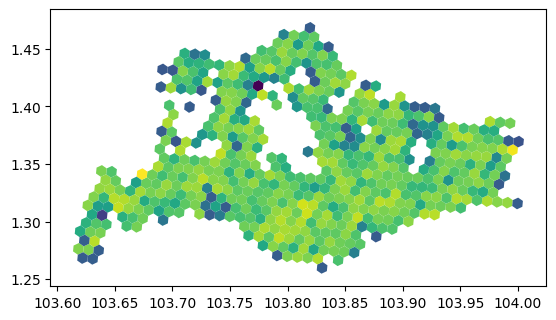

In [56]:
# We first group all start and end node attributes by corresponding hexagonal grid 'hexid'; and compute correlation of GVI between all instances of edges. 
hex_correlation = hex_intersection.groupby('hexid')[['u_Green View', 'v_Green View']].corr(min_periods=30).iloc[0::2,-1]

# Drop multi-layer index column and instantiate correlation values as a pandas dataframe
hexagon_df = pd.DataFrame(hex_correlation).reset_index().drop(columns=['level_1'])

# Rename dataframe columns
hexagon_df.columns = ['hexid', 'assortativity']

# Final Step: Merge correlation information to hex_gdf 
final_gdf = hex_gdf.merge(hexagon_df, on = 'hexid')

# Plotting the final dataframe by `correlation` column
final_gdf.plot(column='assortativity')

#### Improving plot aesthetics

Last, we apply some optional, simple steps to improve the base plot generated above. We use the matplotlib general plotting library to add a title, subtitle, and legend bar. 

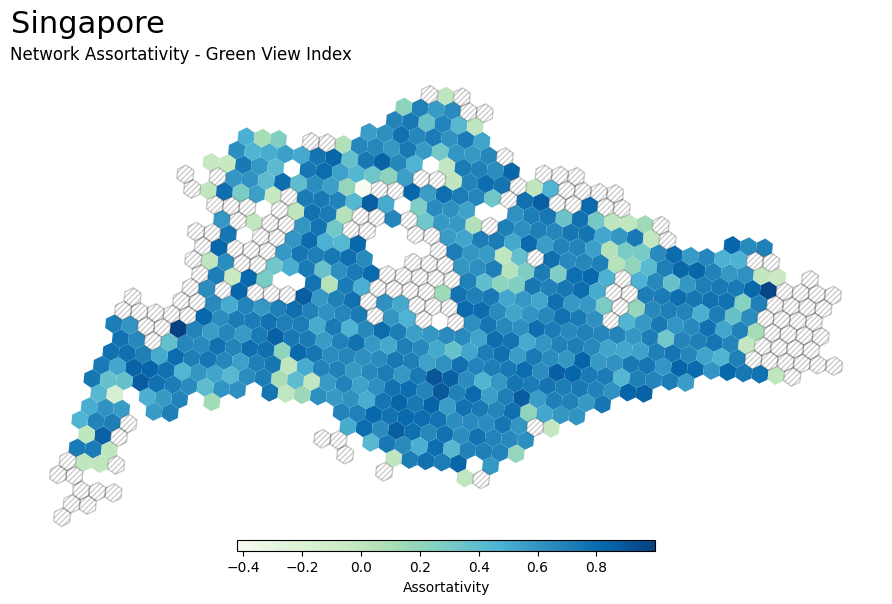

In [57]:
import matplotlib.pyplot as plt

# Instantiate a figure
fig, ax = plt.subplots(figsize=(18, 9))

# Customise plot with colorscale, 
final_gdf.plot(column='assortativity', ax=ax, cmap='GnBu', legend=True, 
               legend_kwds={'label': "Assortativity",
                             'orientation': "horizontal",
                             'shrink': 0.30,
                             'anchor':(0.5, 2.2), 
                             'aspect':40, 
                             'ticks':None},
               missing_kwds={"color": "white",
                              "edgecolor": "black",
                              "hatch": "//////",
                              "alpha":0.2,
                              "label": "Missing values",
                              }
                )

# Turn off x-axis
ax.set_axis_off()

# Add title and subtitles
ax.set_title('Network Assortativity - Green View Index', fontsize=12, loc='left', pad=0)
fig.suptitle('Singapore', fontsize=22, x=0.271, y = 0.94, horizontalalignment='left')

# plt.savefig('./figures/singapore_gvi_assortativity.png', dpi=300)
plt.show()

### Conclusion
We have come a long way, bringing together network structure and semantic information to analyse urban greenery segregation in Singapore. Our observation suggests that urban greenery between adjacent locations in Singapore is generally well balanced, reflecting the success of early planning efforts pursued by the city state (Yuen, 1996; Tan et al., 2013). This notebook is just one of many examples of how contextual information from networks can be employed to understand structures underlying complex urban systems. 

### References

- Newman, M. E. (2003). Mixing patterns in networks. Physical review E, 67(2), 026126.
- Yuen, B. (1996). Creating the garden city: the Singapore experience. Urban studies, 33(6), 955-970.
- Tan, P. Y., Wang, J., & Sia, A. (2013). Perspectives on five decades of the urban greening of Singapore. Cities, 32, 24-32.